<a href="https://colab.research.google.com/github/RohaArslan/COMPUTERVISION/blob/main/Identify_objects_after_morphological_ops.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import cv2
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import os
drive.mount('/content/drive')

Mounted at /content/drive


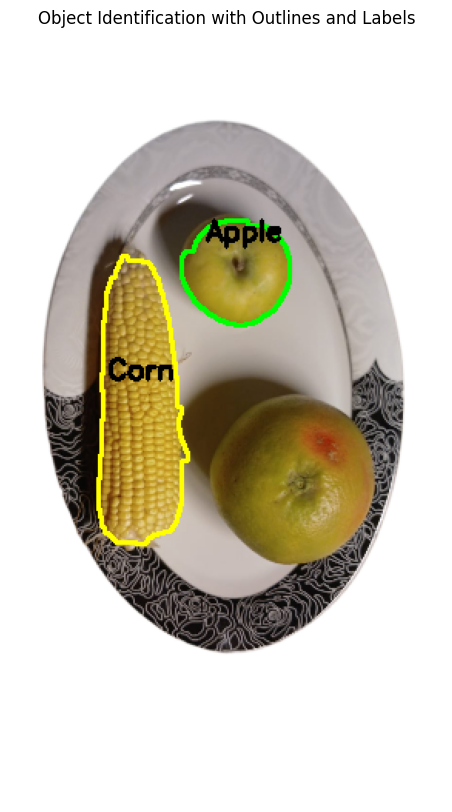

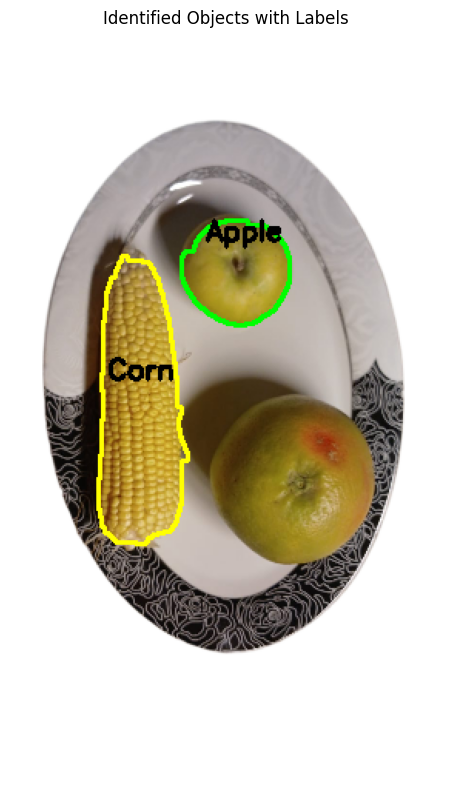

In [3]:
def compute_region_properties(binary_image):
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    properties = []

    for contour in contours:
        area = cv2.contourArea(contour)

        if area < 500:  # Filter out small contours
            continue

        moments = cv2.moments(contour)
        cx = int(moments['m10'] / moments['m00']) if moments['m00'] != 0 else 0
        cy = int(moments['m01'] / moments['m00']) if moments['m00'] != 0 else 0
        centroid = (cx, cy)

        perimeter = cv2.arcLength(contour, True)
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

        # Calculate aspect ratio
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = float(w) / h if h > 0 else 0

        properties.append({'area': area, 'centroid': centroid, 'circularity': circularity, 'aspect_ratio': aspect_ratio, 'contour': contour})

    return properties

def identify_objects(image_path):
    # Load the image
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error: Could not read the image at {image_path}. Please check the path.")
        return None

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define HSV ranges for each object
    # Corn (Bright Yellow)
    lower_corn = np.array([20, 100, 100])
    upper_corn = np.array([30, 255, 255])
    mask_corn = cv2.inRange(hsv, lower_corn, upper_corn)

    # Apple (Red/Green)
    lower_apple = np.array([0, 100, 100])  # Red and Green ranges
    upper_apple = np.array([180, 255, 255])
    mask_apple = cv2.inRange(hsv, lower_apple, upper_apple)

    # Grapefruit (Yellow-Orange)
    lower_grapefruit = np.array([10, 100, 100])
    upper_grapefruit = np.array([25, 255, 255])
    mask_grapefruit = cv2.inRange(hsv, lower_grapefruit, upper_grapefruit)

    # Combine masks to get more comprehensive areas
    combined_mask = cv2.bitwise_or(mask_corn, mask_apple)
    combined_mask = cv2.bitwise_or(combined_mask, mask_grapefruit)

    # Apply morphological operations to reduce noise and fill gaps
    kernel = np.ones((5, 5), np.uint8)
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel)

    # Calculate properties of each region from the combined mask
    combined_regions = compute_region_properties(combined_mask)

    # Visualize contours and their properties on the original image
    contour_image = image.copy()

    # Identify and label each fruit based on regions detected
    for region in combined_regions:
        cx, cy = region['centroid']
        circularity = region['circularity']
        area = region['area']
        aspect_ratio = region['aspect_ratio']

        # Draw contours and labels based on circularity, area, and aspect ratio
        if area > 1000:  # Only consider larger areas
            if circularity < 0.6 and aspect_ratio < 0.6:  # Corn: long, narrow shapes
                cv2.drawContours(contour_image, [region['contour']], -1, (0, 255, 255), 2)  # Yellow for corn
                cv2.putText(contour_image, "Corn", (cx - 20, cy - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
            elif circularity > 0.8 and aspect_ratio > 1:  # Apples: round shapes
                cv2.drawContours(contour_image, [region['contour']], -1, (0, 255, 0), 2)  # Green for apple
                cv2.putText(contour_image, "Apple", (cx - 20, cy - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
            elif circularity >= 0.75 and area > 1000:  # Grapefruits: larger round shapes
                cv2.drawContours(contour_image, [region['contour']], -1, (0, 165, 255), 2)  # Orange for grapefruit
                cv2.putText(contour_image, "Grapefruit", (cx - 20, cy - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)

    # Display the final image with contours and labels
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
    plt.title('Object Identification with Outlines and Labels')
    plt.axis('off')
    plt.show()

    return contour_image  # Return the labeled image

# Replace with the actual path to your image file
image_path = "/content/drive/MyDrive/CV/plate.png"  # Make sure this path is correct

# Check if the file exists
if not os.path.isfile(image_path):
    print(f"Error: The file {image_path} does not exist.")
else:
    labeled_image = identify_objects(image_path)

    # Display the result if the image was processed
    if labeled_image is not None:
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(labeled_image, cv2.COLOR_BGR2RGB))
        plt.title('Identified Objects with Labels')
        plt.axis('off')
        plt.show()